In [15]:
import pandas as pd
import numpy as np
from sklearn.cluster import SpectralClustering
# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# import seaborn as sns
import sklearn.metrics as m
import warnings
warnings.filterwarnings("ignore")

In [16]:
input_path = "../data/features_encoded.csv"
raw_data = pd.read_csv(input_path, header=0, skiprows=None, index_col=None, delimiter=",")

labels = raw_data['malicious'].apply(lambda x: 1 if x else 0)
features = raw_data.drop('malicious', axis=1)

train_features = features.iloc[:80000, :]
test_features = features.iloc[80000:, :]
train_labels = labels[:80000]
test_labels = labels[80000:]

In [17]:
def calculateNormalizationParams(data):
    means = data.mean()
    stdevs = data.std()
    stdevs[stdevs == 0] = 1  # Replace 0 std to avoid division by zero
    return means, stdevs

def applyNormalization(data, means, stdevs):
    return (data - means) / stdevs

In [18]:
means, stdevs = calculateNormalizationParams(train_features)
normalizedTrainFeatures = applyNormalization(train_features, means, stdevs)
normalizedTestFeatures = applyNormalization(test_features, means, stdevs)

In [19]:
best_k = 2
best_classifier = spectral = SpectralClustering(n_clusters=best_k,affinity='nearest_neighbors',random_state=0).fit(normalizedTrainFeatures)
# prev_error = best_classifier.inertia_

In [29]:
spectral = best_classifier
predictions = spectral.fit_predict(normalizedTestFeatures)

In [30]:
if normalizedTrainFeatures.shape[1] in [2, 3]:
    plt.scatter(normalizedTrainFeatures[:, 0], normalizedTrainFeatures[:, 1], c=train_cluster_labels, cmap='viridis')
    plt.title("Spectral Clustering Visualization")
    plt.show()

In [31]:
homogeneity = m.homogeneity_score(test_labels,predictions)
completeness = m.completeness_score(test_labels,predictions)
v_measure = m.v_measure_score(test_labels,predictions)
print("Homogeneity score: " + str(homogeneity))
print("Completeness score: " + str(completeness))
print("V-Measure score: " + str(v_measure))

Homogeneity score: 0.0002814671435983904
Completeness score: 0.014040674596164893
V-Measure score: 0.0005518711718659941


In [32]:
pred2label = {}
for i in range(0,len(predictions)):
    if not str(predictions[i]) in pred2label:
        pred2label.update({str(predictions[i]):{str(test_labels.iloc[i]):1}})
    elif not str(test_labels.iloc[i]) in pred2label[str(predictions[i])]:
        pred2label[str(predictions[i])].update({str(test_labels.iloc[i]):1})
    else:
        cur = int(pred2label[str(predictions[i])][str(test_labels.iloc[i])])
        pred2label[str(predictions[i])][str(test_labels.iloc[i])] = str(cur + 1)
for cluster in pred2label:
    bcount = int(pred2label[cluster]["0"]) if "0" in pred2label[cluster] else 0
    mcount = int(pred2label[cluster]["1"]) if "1" in pred2label[cluster] else 0
    if bcount > mcount:
        # pred2label[cluster]["label"] = 0
        pred2label[cluster]["probability"] = float(bcount)/float(bcount+mcount)
    else:
        # pred2label[cluster]["label"] = 1
        pred2label[cluster]["probability"] = float(mcount)/float(bcount+mcount)

In [33]:
def getProb(x):
    return pred2label[str(x)]["probability"]
probs = [getProb(x) for x in predictions]

In [34]:
acc = m.accuracy_score(test_labels, predictions)
prec = m.precision_score(test_labels, predictions)
recall = m.recall_score(test_labels, predictions)
f1 = m.f1_score(test_labels,predictions)
auc = m.roc_auc_score(test_labels,probs)
print("Accuracy score: " + str(acc))
print("Precision score: " + str(prec))
print("Recall score: " + str(recall))
print("F1 score: ", f1)
print("AUC-ROC: ", auc)

Accuracy score: 0.5991700414979251
Precision score: 0.1891891891891892
Recall score: 0.0008756567425569177
F1 score:  0.0017432449259120908
AUC-ROC:  0.4991885571128459


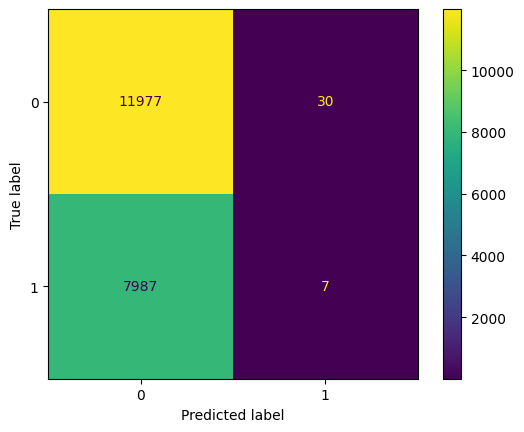

In [35]:
m.ConfusionMatrixDisplay(m.confusion_matrix(test_labels, predictions)).plot()

In [36]:
import pickle
with open('trained_models/spectral.pkl','wb') as f:
    pickle.dump(spectral,f)
print("Model dump complete!")

Model dump complete!
